# Import libraries

In [16]:
import pandas as pd
import numpy as np

# Enable interactive Matplotlib plots in the notebook
# %matplotlib qt5


import matplotlib.pyplot as plt
from matplotlib import cm
import os
import astropy.convolution as krn
import scipy.stats as stats
import sys

import matplotlib.pyplot as plt
from matplotlib.widgets import Button



# Interactive Plotting Class

In [17]:
# class for interactive 2D plot

# Create a custom class to handle button clicks
class PlotUpdater:
    def __init__(self, ax, df, plot_type='2D'):
        self.ax = ax
        self.df = df
        self.plot_type = plot_type
        self.current_index = 0
        self.button_next = Button(ax, 'Next', color='lightgoldenrodyellow', hovercolor='0.975')
        self.button_prev = Button(ax, 'Previous', color='lightgoldenrodyellow', hovercolor='0.975')
        self.button_next.on_clicked(self.next_click)
        self.button_prev.on_clicked(self.prev_click)        
        
        # Set text color for the buttons to black
        self.button_next.label.set_color('black')
        self.button_prev.label.set_color('black')
        
    def next_click(self, event):
        if self.current_index < len(self.df.trialNr.unique()) - 1:
            self.current_index += 1
            self.update_plot()
        else:
            self.current_index = self.current_index - len(self.df.trialNr.unique()) # if at the end of df, wrap over to start of df
            self.update_plot()

    def prev_click(self, event):
        if self.current_index > 0:
            self.current_index -= 1
            self.update_plot()
        else:
            self.current_index = self.current_index + len(self.df.trialNr.unique())-1 # if at the start of df, wrap over to end of df
            self.update_plot()

    def update_plot(self):
        self.ax.clear()               
        
        # select a trial based on current_index
        current_trial = self.df.trialNr.unique()[self.current_index]
        df = self.df[self.df.trialNr == current_trial]
        
        if self.plot_type == '2D':        
            # plot 2D graph       
            self.plot2D(df, current_trial = current_trial)
        else:        
            # plot 1D graph
            self.plot1D(df, current_trial = current_trial)       

        
    def plot2D(self, df, current_trial):
        

        # plot raw samples
        self.ax.scatter(df['user_pred_px_x'], df['user_pred_px_y'], c='orange', alpha=0.5, edgecolors='black', label='raw samples')

        # plot fixations and remove no fixations/saccades (zeros)
        self.ax.scatter(df['FixXPos'][df['FixXPos']>0], df['FixYPos'][df['FixYPos']>0], c='blue', alpha=0.5, edgecolors='black', label='fixations')
        
        # plot target and fixation cirle
        self.ax.scatter(df.fixationStimX, df.fixationStimY, c='red')
        self.ax.scatter(df.targetX, df.fixationStimY, c='green')
        
        # plot target and fixation vertical lines
        self.ax.plot(np.ones(df.resY.iloc[0].astype('int')) * df.fixationStimX.iloc[0], np.arange(df.resY.iloc[0]), c='red', lw=1, linestyle='dashed')
        self.ax.plot(np.ones(df.resY.iloc[0].astype('int')) * df.targetX.iloc[0], np.arange(df.resY.iloc[0]), c='green', lw=1, linestyle='dashed')

        # set axis limits based on screen resolution
        self.ax.set_xlim((0, df.resX.iloc[0]))
        self.ax.set_ylim((df.resY.iloc[0]), 0)
        
        # label the axes
        self.ax.set_xlabel('Horizontal eye position (pixels)')
        self.ax.set_ylabel('Vertical eye position (pixels)')
        
        self.ax.legend()
        self.ax.set_title(f'Target {df.target.iloc[0]}, Trial {current_trial}')    
        self.ax.grid(True)
        
        plt.draw()
        
   

    def plot1D(self, df, current_trial):  
                     
        # rescale time variable to start from zero
        t = np.array(df.sampTime)
        t = t-t[0]
        
               
        # plot raw points and fixations
        self.ax.scatter(t, df.user_pred_px_x, c='orange', alpha=0.5, edgecolors='black', label='raw_samples')
        self.ax.scatter(t, df.FixXPos, c='blue', alpha=0.5, edgecolors='black', label='fixations')
        
        # add target and fixaton horizontal lines
        self.ax.plot(t, df.targetX, c='green', lw=1)
        self.ax.plot(t, df.fixationStimX, c='red', lw=1, linestyle='dashed')
        
        # label the axes
        self.ax.set_xlabel('Time (ms)')
        self.ax.set_ylabel('Horizontal eye position (pixels)')
        
        # set axis limits based on horizantal resolution
        self.ax.set_ylim((df.resX.iloc[0]), 0)
        
        # plot saccade latency as a horizontal line
        self.ax.plot(np.array([df.SaccLat.iloc[0]] * df.resX.iloc[0].astype(int)), np.arange(df.resX.iloc[0]), c='black', lw=1)
        
        
        # set the rest
        self.ax.set_title(f'Target {df.target.iloc[0]}, Trial {current_trial}')
        self.ax.legend()
        self.ax.grid(True)
        
        plt.draw()    

In [18]:
def makeHeat(screenRes, xPos, yPos):
        xMax = screenRes[0]
        yMax = screenRes[1]
        xMin = 0
        yMin = 0
        kernelPar = 50

        # Input handeling
        xlim = np.logical_and(xPos < xMax, xPos > xMin)
        ylim = np.logical_and(yPos < yMax, yPos > yMin)
        xyLim = np.logical_and(xlim, ylim)
        dataX = xPos[xyLim]
        dataX = np.floor(dataX)
        dataY = yPos[xyLim]
        dataY = np.floor(dataY)

        # initiate map and gauskernel
        gazeMap = np.zeros([int((xMax-xMin)),int((yMax-yMin))])+0.0001
        gausKernel = krn.Gaussian2DKernel(kernelPar)

        # Rescale the position vectors (if xmin or ymin != 0)
        dataX -= xMin
        dataY -= yMin

        # Now extract all the unique positions and number of samples
        xy = np.vstack((dataX, dataY)).T
        uniqueXY, idx, counts = uniqueRows(xy)
        uniqueXY = uniqueXY.astype(int)
        # populate the gazeMap
        gazeMap[uniqueXY[:,0], uniqueXY[:,1]] = counts

        # Convolve the gaze with the gauskernel
        heatMap = np.transpose(krn.convolve_fft(gazeMap,gausKernel))
        heatMap = heatMap/np.max(heatMap)

        return heatMap

def uniqueRows(x):
    y = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, idx, counts = np.unique(y, return_index=True, return_counts = True)
    uniques = x[idx]
    return uniques, idx, counts


def np_euclidean_distance(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.sum(np.square(y_pred - y_true), axis=-1))



# Preprocess, extract fixations and add them to the dataframe

In [19]:
sys.path.append('./FixationDetection')
from FixationDetection.I2MC import runI2MC

# Path to data folders
path_to_folders = 'C:/Users/aby600/Dropbox/Appliedwork/CognitiveSolutions/Projects/DeepEye/TechnicalReports/TechnicalReport1/Test_MullerLyer/pilot3'
# path_to_folders = 'D:/Dropbox/Appliedwork/CognitiveSolutions/Projects/DeepEye/TechnicalReports/TechnicalReport1/Test_MullerLyer/pilot'

# get all folder names
folder_names = os.listdir(path_to_folders)

# read and process original datafile for each participant
for fn in folder_names:
    path = os.path.join(path_to_folders, fn, fn+'_record.csv')       
        
    df = pd.read_csv(path, on_bad_lines='skip')        

# order frames and drop duplicate samples (with same sampleTime)
df = df[df.fName.notna()]
df.frameNr = df.frameNr.apply(pd.to_numeric, errors='coerce') # if framerNr is not a number, it is replaces with nan
df = df[df.frameNr.notna()] # filter out rows where frameNr is a nan

df = df[df.sampTime.notna()]
df = df[df.user_pred_px_x.notna()]
df = df[df.user_pred_px_y.notna()]
df = df.apply(pd.to_numeric, errors='ignore') # if str convert str to numbers

df = df.sort_values('frameNr')
df = df.reset_index(drop=True)
# df = df.drop_duplicates(subset=['user_pred_px_x', 'user_pred_px_y'], ignore_index=True)
df = df.drop_duplicates(subset=['sampTime'], ignore_index=True)

# get fixations for the original datafile for each participant
fixDF = runI2MC(path, plotData = False)

# add extracted fixations to the original data file (two new columns)
# for each timestamp where fixation was detected, FixXPos and FixYPos are added
idx = 0 # index of fixDF
FixXPos = np.zeros(df.shape[0])
FixYPos = np.zeros(df.shape[0])
FixStartEnd = np.empty(df.shape[0], dtype='U10')
FixStartEnd.fill('') # explicitly fill the array (good practice)

DistFromPrevFix = np.zeros(df.shape[0])
PrevFixXPos = np.zeros(df.shape[0])
PrevFixYPos = np.zeros(df.shape[0])
prev_fix_x = False # keep track of xy when fixation ends
prev_fix_y = False

PrevFixSampTime = np.zeros(df.shape[0])
prev_fix_sampTime = 0

# iterate thru the original dataframe, thru each sample
for index, row in df.iterrows():
    
    # make sure not to iterate out of range
    if idx < fixDF.shape[0]:
        
        # go to next fixation when fixation ends
        if row['sampTime'] > np.array(fixDF.FixEnd)[idx]:
                idx += 1
        
        # make sure not to iterate out of range
        if idx < fixDF.shape[0]:
            
            # when samples are within fixation, accumulate FixXPos and FixYPos
            if row['sampTime'] >= np.array(fixDF.FixStart)[idx] and row['sampTime'] <= np.array(fixDF.FixEnd)[idx]:

                FixXPos[index] = (np.array(fixDF.XPos)[idx])
                FixYPos[index] = (np.array(fixDF.YPos)[idx])
            
            # label samples on which fixation starts and ends
            if row['sampTime'] == np.array(fixDF.FixStart)[idx]:             
                FixStartEnd[index] = 'fix_start'
                
                if prev_fix_x != False:
                    
                    PrevFixXPos[index] = prev_fix_x
                    PrevFixYPos[index] = prev_fix_y
                    
                    DistFromPrevFix[index] = np.sqrt((np.array(fixDF.XPos)[idx] - prev_fix_x)**2 
                                            + (np.array(fixDF.YPos)[idx] - prev_fix_y)**2)
                    PrevFixSampTime[index] = prev_fix_sampTime
                    
            
            elif row['sampTime'] == np.array(fixDF.FixEnd)[idx]:                
                FixStartEnd[index] = 'fix_end'             
                                    
                prev_fix_x = np.array(fixDF.XPos)[idx]
                prev_fix_y = np.array(fixDF.YPos)[idx]
                prev_fix_sampTime = np.array(row['sampTime'])
                
       

 
# add fixations to original dataframe
df['FixXPos'] = np.array(FixXPos)
df['FixYPos'] = np.array(FixYPos)
df['FixStartEnd'] = FixStartEnd
df['DistFromPrevFix'] = DistFromPrevFix
df['PrevFixSampTime'] = PrevFixSampTime
df['PrevFixXPos'] = PrevFixXPos
df['PrevFixYPos'] = PrevFixYPos


# Extract only samples when the target was presented
df = df[df.event=='target_on']

# Label trials with too few data points
a = df.groupby('trialNr').count().reset_index()
a = a[['trialNr', 'sampTime']]
# 3) rename the columns so they would be added
a.columns = ['trialNr', 'samplesPerTrial']
df = pd.merge(df, a, on="trialNr")


C:\Users\aby600\AppData\Local\Temp\ipykernel_25724\1102232601.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore') # if str convert str to numbers
c:\Users\aby600\Documents\GitHub\DeepEye_analyze\FixationDetection\I2MC.py:52: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  origData = origData.apply(pd.to_numeric, errors='ignore')





Importing and processing: "C:/Users/aby600/Dropbox/Appliedwork/CognitiveSolutions/Projects/DeepEye/TechnicalReports/TechnicalReport1/Test_MullerLyer/pilot3\2024_10_13_14_20_16\2024_10_13_14_20_16_record.csv"
	Searching for valid interpolation windows
	Replace interpolation windows with Steffen interpolation
	2-Means clustering started for averaged signal


c:\Users\aby600\Documents\GitHub\DeepEye_analyze\FixationDetection\import_funcs.py:124: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.apply(pd.to_numeric, errors='ignore')


	Determining fixations based on clustering weight mean for averaged signal and separate eyes + 2*std


I2MC took 5.332590579986572s to finish!


c:\USERS\ABY600\DOCUMENTS\GITHUB\DEEPEYE_ANALYZE\DEEPEYE_ANALYZE\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\USERS\ABY600\DOCUMENTS\GITHUB\DEEPEYE_ANALYZE\DEEPEYE_ANALYZE\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\USERS\ABY600\DOCUMENTS\GITHUB\DEEPEYE_ANALYZE\DEEPEYE_ANALYZE\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Get and plot saccade latency distribution

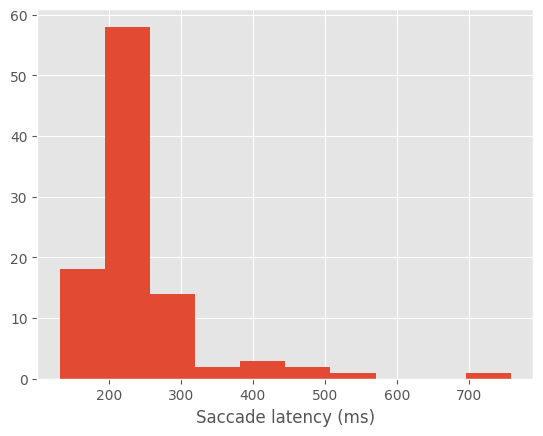

In [20]:
# Get saccade latency

def getSaccLat(df):    

    # Get timestamp of when target was presented and add it to the dataframe

    # 1) get the first time sample when the target is presented
    sampTime_df = df.drop_duplicates(subset=['trialNr'],  keep='first', ignore_index=True)

    # 2)extract the columns needed
    sampTime_df = sampTime_df[['trialNr', 'sampTime']]

    # 3) rename the columns so they would be added
    sampTime_df.columns = ['trialNr', 'targSampTime']

    # 4) merge the target time into the main df (one time per trial)
    df = pd.merge(df, sampTime_df, on="trialNr")

    # Extract saccade latencies

    # 1) select only rows where fixation started
    sl_df = df[df.FixStartEnd == 'fix_start']

    # 2) select only rows with large enough preceeding saccade
    sl_df = sl_df[sl_df.DistFromPrevFix > 300]

    # 3) compute first fixation duration (saccade latency)
    sl_df['SaccLat'] = sl_df.PrevFixSampTime - sl_df.targSampTime

    # 4) remove rows where negative Saccade Latencies for trials where no fixation end is present
    sl_df = sl_df[sl_df.SaccLat > 0]
    
    return sl_df

# 5) plot saccade latencies
sl_df = getSaccLat(df)

plt.figure()
plt.style.use('ggplot')
plt.hist(sl_df.SaccLat)
plt.xlabel('Saccade latency (ms)')

# 6) merge saccade latencies into main df
sl_df = sl_df[['trialNr', 'SaccLat']]
df = pd.merge(df, sl_df, on="trialNr")

# save figure
# plt.savefig('./Figures_MullerLyer/saccade_latency.jpg', dpi=1000, pad_inches=0)


# 1D Plot to compare raw samples to fixations

### 1. Plot separately for target left and target right
### 2. while looping through each trial
    a. rescale time variable to start from 0
    b. plot all raw x
    c. plot all fixationXPos
    d. zeros indicate saccade/no fixation

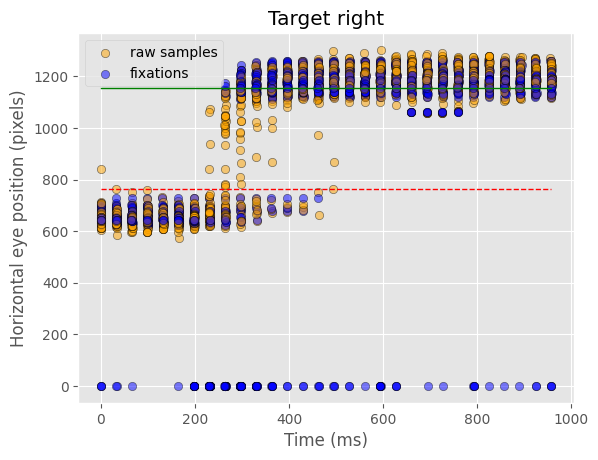

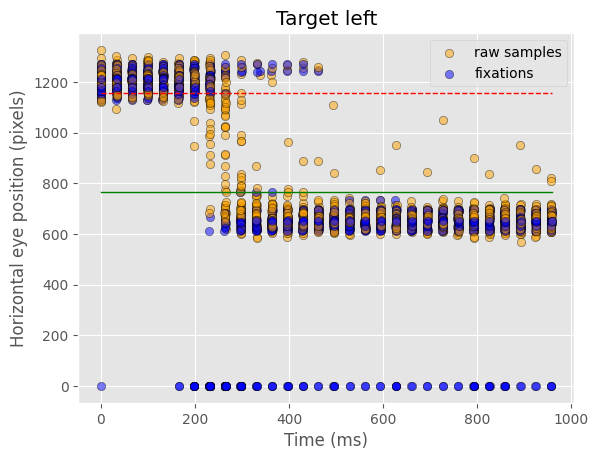

In [21]:

conditions = ['right', 'left']


for cond in conditions:
    
    plt.figure()
    plt.style.use('ggplot')
    plt.title(f'Target {cond}')
    
    a = df[df.target==cond]

    for name, group in a.groupby('trialNr'):
        t = np.array(group.sampTime)
        t = t-t[0]
        raw_h = plt.scatter(t, group.user_pred_px_x, c='orange', alpha=0.5, edgecolors='black')
        fix_h = plt.scatter(t, group.FixXPos, c='blue', alpha=0.5, edgecolors='black')

    plt.plot(t, group.targetX, c='green', lw=1)
    plt.plot(t, group.fixationStimX, c='red', lw=1, linestyle='dashed')
    
    plt.xlabel('Time (ms)')
    plt.ylabel('Horizontal eye position (pixels)')
    
    plt.legend((raw_h, fix_h), ('raw samples', 'fixations'), scatterpoints=1)
    
    # save figure
#     plt.savefig(f'./Figures_MullerLyer/1D_{cond}.jpg', dpi=1000, pad_inches=0)


# Interactive 1D plot

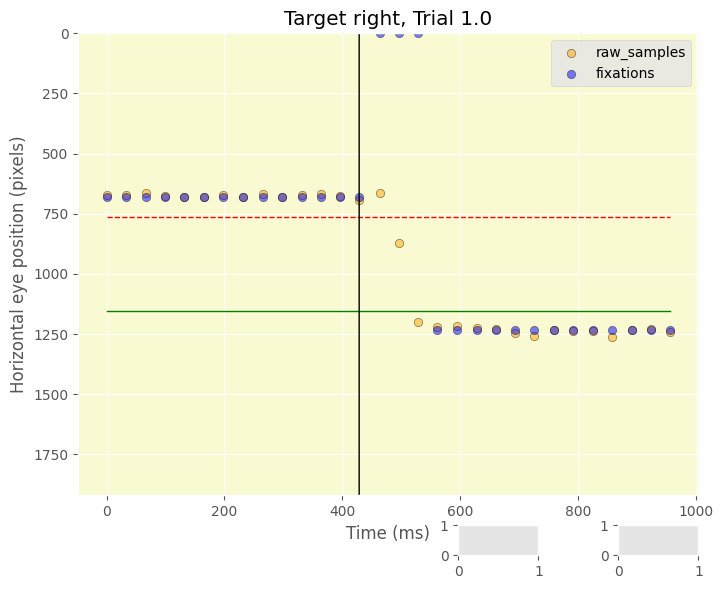

In [22]:
# Create a figure and initialize the plot
fig, ax = plt.subplots(figsize=(8, 6))
plot_updater = PlotUpdater(ax, df, plot_type='1D')
plot_updater.update_plot()

# Position the 'Next' and 'Previous' buttons at the bottom of the plot
button_ax_prev = plt.axes([0.6, 0.01, 0.1, 0.05])
button_ax_next = plt.axes([0.8, 0.01, 0.1, 0.05])

plot_updater.button_next.ax = button_ax_next
plot_updater.button_prev.ax = button_ax_prev

plt.show()

# 2D plot of fixations and raw samples

## 1. plot all raw x,y
## 2. plot all fixations x,y 


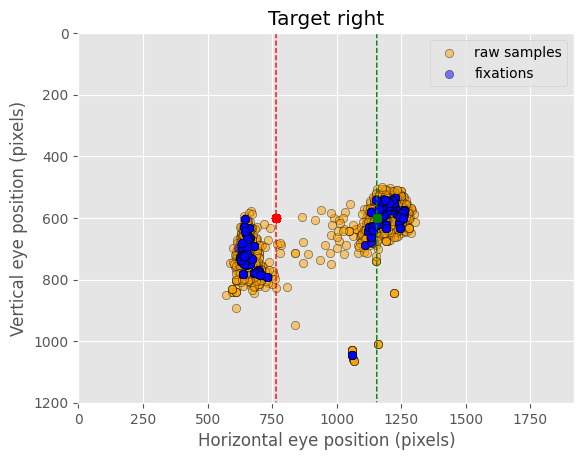

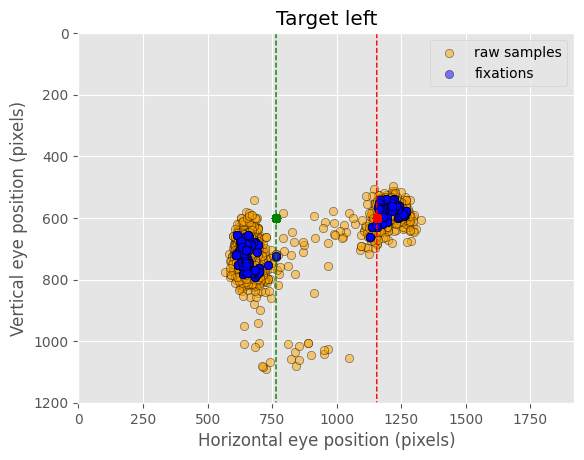

In [23]:
conditions = ['right', 'left']


for cond in conditions:
    
    plt.figure()
    plt.style.use('ggplot')
    plt.title(f'Target {cond}')
        
    # select condition
    a = df[df.target==cond]
            
    raw_h = plt.scatter(a.user_pred_px_x, a.user_pred_px_y, c='orange', alpha=0.5, edgecolors='black')
    
     # remove no fixations/saccades (zeros)
    fix_h = plt.scatter(a.FixXPos[a.FixXPos>0], a.FixYPos[a.FixYPos>0], c='blue', alpha=0.5, edgecolors='black')
    
    # plot target and fixation cirle
    plt.scatter(a.fixationStimX, a.fixationStimY, c='red')
    plt.scatter(a.targetX, a.fixationStimY, c='green')
    
    # plot target and fixation vertical lines
    plt.plot(np.ones(df.resY.iloc[0].astype('int')) * a.fixationStimX.iloc[0], np.arange(df.resY.iloc[0]), c='red', lw=1, linestyle='dashed')
    plt.plot(np.ones(df.resY.iloc[0].astype('int')) * a.targetX.iloc[0], np.arange(df.resY.iloc[0]), c='green', lw=1, linestyle='dashed')
    
    plt.xlim((0, df.resX.iloc[0]))
    plt.ylim((df.resY.iloc[0]), 0)
    
    plt.xlabel('Horizontal eye position (pixels)')
    plt.ylabel('Vertical eye position (pixels)')
    
    plt.legend((raw_h, fix_h), ('raw samples', 'fixations'), scatterpoints=1)
    
    # save figure
#     plt.savefig(f'./Figures_MullerLyer/2D_{cond}.jpg', dpi=1000, pad_inches=0)


# Interactive 2D plot for every trial

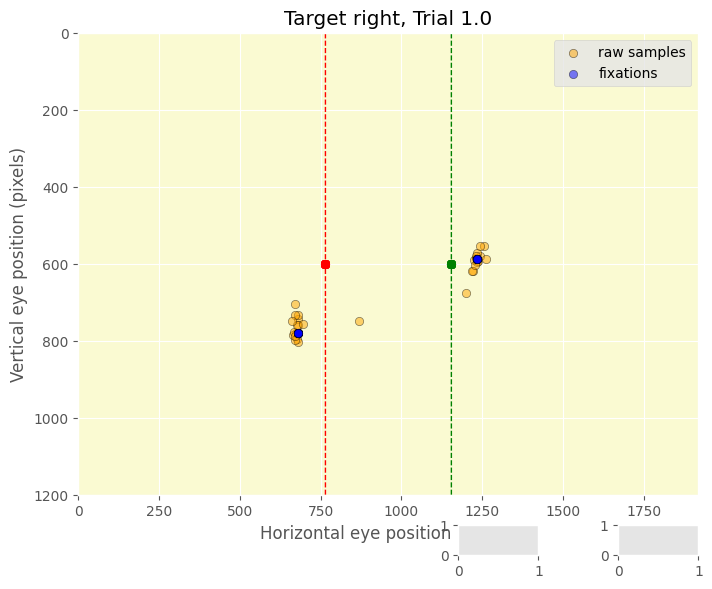

In [24]:
# Create a figure and initialize the plot
fig, ax = plt.subplots(figsize=(8, 6))
plot_updater = PlotUpdater(ax, df, plot_type='2D')
plot_updater.update_plot()

# Position the 'Next' and 'Previous' buttons at the bottom of the plot
button_ax_prev = plt.axes([0.6, 0.01, 0.1, 0.05])
button_ax_next = plt.axes([0.8, 0.01, 0.1, 0.05])

plot_updater.button_next.ax = button_ax_next
plot_updater.button_prev.ax = button_ax_prev

plt.show()

# Compare landing position between outward and inward arrows

In [25]:
def plot_fixationsOutIn(df, cond='', agg='median', title=''):
    
    plt.style.use('ggplot')
#     plt.grid(False)
#     plt.set_axis_bgcolor('white')
    
    
    out = df[df.condition=='arrowHeadsOutward']
    inw = df[df.condition=='arrowHeadsInward']

    if agg=='median':
        
        outX = out.FixXPos.median()
        outY = out.FixYPos.median()

        inwX = inw.FixXPos.median()
        inwY = inw.FixYPos.median()
        
    elif agg=='mean':
        
        outX = out.FixXPos.mean()
        outY = out.FixYPos.mean()

        inwX = inw.FixXPos.mean()
        inwY = inw.FixYPos.mean()
        
        

    plt.figure()    
    plt.title(title);
    
    
    out_h = plt.scatter(out.FixXPos, out.FixYPos, c='blue', alpha=0.5, edgecolors='black')
    inw_h = plt.scatter(inw.FixXPos, inw.FixYPos, c='orange', alpha=0.5,edgecolors='black')
    
    plt.scatter(out.fixationStimX, out.fixationStimY, c='red')
    plt.scatter(out.targetX, out.fixationStimY, c='green')
    
    
    # plot target and fixation vertical lines
    plt.plot(np.ones(df.resY.iloc[0].astype('int')) * df.fixationStimX.iloc[0], np.arange(df.resY.iloc[0]), c='red', lw=1, linestyle='dashed')
    plt.plot(np.ones(df.resY.iloc[0].astype('int')) * df.targetX.iloc[0], np.arange(df.resY.iloc[0]), c='green', lw=1, linestyle='dashed')    

    plt.scatter(outX, outY, c='purple', edgecolors='black')
    plt.scatter(inwX, inwY, c='darkorange', edgecolors='black')
    
    # plot inward and outward vertical lines
    plt.plot(np.ones(df.resY.iloc[0].astype('int')) * outX, np.arange(df.resY.iloc[0]), c='purple', lw=1, linestyle='dashed')
    plt.plot(np.ones(df.resY.iloc[0].astype('int')) * inwX, np.arange(df.resY.iloc[0]), c='darkorange', lw=1, linestyle='dashed')    
    
    plt.xlim((0, df.resX.iloc[0]))
    plt.ylim((df.resY.iloc[0], 0))
    
    plt.xlabel('Horizontal eye position (pixels)')
    plt.ylabel('Vertical eye position (pixels)')
    
    plt.legend((out_h, inw_h), ('outward arrowheads', 'inward arrowheads'), scatterpoints=1)
    
    
    plt.text(150,700,f'Outward Arrow Xpos: {np.round(outX,1)}')
    plt.text(150,750,f'Inward Arrow Xpos: {np.round(inwX, 1)}')
    
    # save figure
#     plt.savefig(f'./Figures_MullerLyer/{cond}_OutInw.jpg', dpi=1000, pad_inches=0)


    return outX, outY, inwX, inwY



Target Left Outward Arrow: 651.9069211748183
Target Left Inward Arrow: 648.2971591485211
Target Right Outward Arrow: 1182.9021651549608
Target Right Inward Arrow: 1187.3645593766994


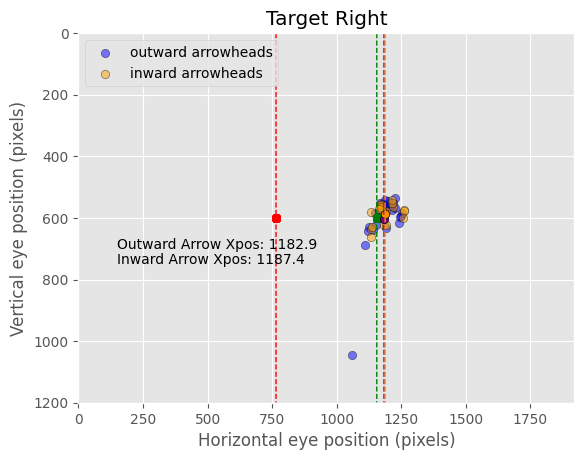

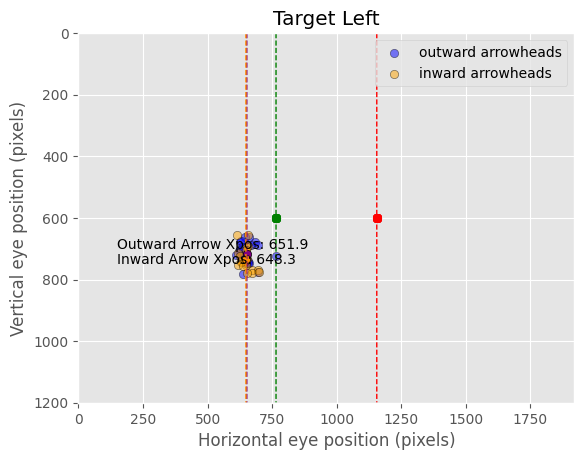

In [26]:
# Min distance from fixaton to target or fixation point in pixels
pix_in_cm = df.resX.iloc[0]/df.scrW_cm.iloc[0]
minDist = pix_in_cm * 15

# select rows where fixation started (they also have information about when previous fixation ended)
i_df = df[df.FixStartEnd == 'fix_start']

# get samples with large enough preceeding saccade
i_df = i_df[i_df.DistFromPrevFix > 300]

# select rows where Saccade Latencies are positive (negative menas that trials have no fixation end is present)
i_df = i_df[i_df.SaccLat > 50]

# select rows where Saccade latencies are fast
i_df = i_df[i_df.SaccLat < 300]

# select rows where Saccade lands close to the target
targets = np.c_[np.array(i_df.targetX), np.array(i_df.fixationStimY)] # get a target vector
fixations = np.c_[np.array(i_df.FixXPos), np.array(i_df.FixYPos)] # get a fixation vector
DistFix2Targ = np_euclidean_distance(targets, fixations) # compute vector of distances from fixation to target
i_df['DistFix2Targ'] = DistFix2Targ
i_df = i_df[i_df.DistFix2Targ <= minDist]

# select rows where Saccade starts close to the fixation point
fixation_points = np.c_[np.array(i_df.fixationStimX), np.array(i_df.fixationStimY)] # get a fixation points vector
prev_fixations = np.c_[np.array(i_df.PrevFixXPos), np.array(i_df.PrevFixYPos)] # get a fixation vector of first fixations in the trial (when fixating the fixation point)
DistPrevFix2FixPoint = np_euclidean_distance(fixation_points, prev_fixations) # compute vector of distances from previous fixation to fixation point

i_df['DistPrevFix2FixPoint'] = DistPrevFix2FixPoint
i_df = i_df[i_df.DistPrevFix2FixPoint <= minDist]

# filter out trials with too few samples
i_df = i_df[i_df.samplesPerTrial > 0]

Left = i_df[i_df.target=='left']
out = Left[Left.condition=='arrowHeadsOutward']
inw = Left[Left.condition=='arrowHeadsInward']
print(f'Target Left Outward Arrow: {out.FixXPos.mean()}')
print(f'Target Left Inward Arrow: {inw.FixXPos.mean()}')

Right = i_df[i_df.target=='right']
out = Right[Right.condition=='arrowHeadsOutward']
inw = Right[Right.condition=='arrowHeadsInward']
print(f'Target Right Outward Arrow: {out.FixXPos.mean()}')
print(f'Target Right Inward Arrow: {inw.FixXPos.mean()}')


# Plot
summary_right = plot_fixationsOutIn(Right, cond='right', agg='mean', title='Target Right')
summary_left = plot_fixationsOutIn(Left, cond='left', agg='mean', title='Target Left')

